# HW3 Assignment II Notebook
### This notebook contains the second deliverable for HW3
This deliverable presents the initial steps of a data analysis using the Citibike Punblic Datasets

The general flow of the notebook follows:

1) Present the general idea and state my Null and Alternate Hypothesis

2) Fetch the Citibike Data from the AWS Blob and store a local copy

3) Use pandas to read in the local copy of the CitiBike files,into a DF

4) Display the top few rows of the DF in your notebook. This table must be rendered.

5) Display the reducted dataframe. This table must be rendered.

6) Plot your data distributions.

### Idea: There is higher usage of citibikes during rush hours on weekdays than during the same hours on weekends

#### Rush Hours is defined by the following intervals: 6:30 - 9:30 a.m.,3:30 - 8 p.m (http://web.mta.info/nyct/subway/howto_sub.htm)

#### H0 The ratio of rush hour trips to non-rush hour trips on weekdays is the same or lower than the ratio of rush hour trips to non-rush hour trips on weekends.

#### H1 The ratio of rush hour trips to non-rush our trips on weekdays is higher than the ration of rush hour trips to non rush hour trips on weekdends.

In [2]:
#Import modules, initialize the random generator
from __future__ import print_function
import pandas as pd
import numpy as np
import pylab as pl
import os
import matplotlib.mlab as mlab

%pylab inline

#puidir = os.getenv("PUIDATA")
#print (puidir)

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Helper function to download local copies of the Citibike data by Federica Bianco
#https://github.com/fedhere/PUI2016_fb55/blob/master/HW3_fb55/citibikes_gender.ipynb

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
#Download the data using Federica's helper function
datestring = '201401'
getCitiBikeCSV(datestring)

file in place, you can continue


In [9]:
#Read the CSV into a data framw
df=pd.read_csv(os.getenv("PUIDATA")+'/' + datestring + '-citibike-tripdata.csv')

#Handle conversion of the string date into a new date collumn
df['date'] = pd.to_datetime(df['starttime'])
df['dateIndex'] = pd.to_datetime(df['starttime'])
df.head(4)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,dateIndex
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1,2014-01-01 00:00:06,2014-01-01 00:00:06
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1,2014-01-01 00:00:38,2014-01-01 00:00:38
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.754601,-73.971879,2022,E 59 St & Sutton Pl,40.758491,-73.959206,16613,Subscriber,1991,1,2014-01-01 00:03:59,2014-01-01 00:03:59
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.751884,-73.977702,526,E 33 St & 5 Ave,40.747659,-73.984907,15938,Subscriber,1989,1,2014-01-01 00:05:15,2014-01-01 00:05:15


In [10]:
#Selecting the columns that are necessary for the analsis
df = df[['date','dateIndex']]


df.set_index('dateIndex', inplace = True)
df.head()


,date
dateIndex,
2014-01-01 00:00:06,2014-01-01 00:00:06
2014-01-01 00:00:38,2014-01-01 00:00:38
2014-01-01 00:03:59,2014-01-01 00:03:59
2014-01-01 00:05:15,2014-01-01 00:05:15
2014-01-01 00:05:18,2014-01-01 00:05:18


In [11]:
#Create a dataframe contining the rush hour trips, using the dataframe between_time method.
#The method allows selecting values between particular times of the day
#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.between_time.html
#http://stackoverflow.com/questions/24576786/how-to-use-dataframe-between-time-function 

#We take the MTA informal definition of rush hours: 
#(approximately 6:30 - 9:30 a.m., and approximately 3:30 - 8 p.m)
#http://web.mta.info/nyct/subway/howto_sub.htm

df_rushMorning = df.between_time("6:30","9:30")
df_rushEvening = df.between_time("15:30","20:00")
df_rush = pd.concat(([df_rushMorning,df_rushEvening]))
df_rush.head()

,date
dateIndex,
2014-01-01 06:31:48,2014-01-01 06:31:48
2014-01-01 06:32:08,2014-01-01 06:32:08
2014-01-01 06:32:15,2014-01-01 06:32:15
2014-01-01 06:32:40,2014-01-01 06:32:40
2014-01-01 06:34:06,2014-01-01 06:34:06


In [78]:
#Create a dataframe containing the non rush hour trips, using the dataframe between_time method.

df_nonRushDay = df.between_time("9:30","15:30")
df_nonRushNight = df.between_time("20:00","6:30")
df_nonRush = pd.concat(([df_nonRushDay,df_nonRushNight]))
df_nonRush.head()

,date
dateIndex,
2014-01-01 09:30:52,2014-01-01 09:30:52
2014-01-01 09:30:58,2014-01-01 09:30:58
2014-01-01 09:31:20,2014-01-01 09:31:20
2014-01-01 09:31:36,2014-01-01 09:31:36
2014-01-01 09:31:38,2014-01-01 09:31:38


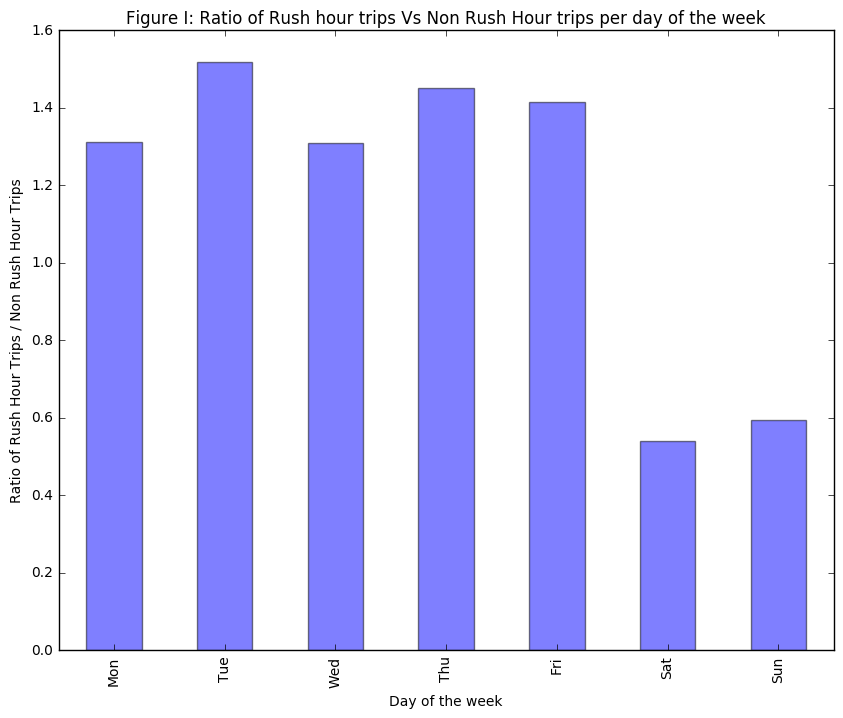

In [99]:
#Plotting the data for both dataframes trying to express the difference that we sustain on the hypotesis

fig=pl.figure(figsize(10,8))

# Agregate the data for each of the dataframws by day of the week
df_countRushDay = df_rush.date.groupby([df_rush.date.dt.weekday]).count()
df_countNonRushDay = df_nonRush.date.groupby([df_nonRush.date.dt.weekday]).count()

#print (df_countNonRushDay)
#print (df_countRushDay)

#The ratio between rush hour trips and Non Rush Hour Trips
      
ax = ((df_countRushDay/df_countNonRushDay)).plot(kind="bar", alpha=0.5)
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=10)
ax.set_ylabel ("Ratio of Rush Hour Trips / Non Rush Hour Trips")
ax.set_xlabel ("Day of the week")
ax.set_title ('Figure I: Ratio of Rush hour trips Vs Non Rush Hour trips per day of the week', fontsize = 12)


In [101]:
print ("The average ratio rush hour trips / non rush hour trips during the week is: "
       + str(((df_countRushDay/df_countNonRushDay)[:5]).mean()))

print ("The average ratio rush hour trips / non rush hour trips during the weekends is: "
       + str(((df_countRushDay/df_countNonRushDay)[5:]).mean()))

The average ratio rush hour trips / non rush hour trips during the week is: 1.40114423027
The average ratio rush hour trips / non rush hour trips during the weekends is: 0.568449221863
